In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from glob import glob
import fiona
from shapely.geometry import Polygon
import seaborn as sns
import random
from skimage.transform import rescale, resize

from utils.data_interface import Dataset, Data_Interface

# Define Interface

## Define Date

In [4]:
class Config():
    dates = ['20190703', '20190719', '20190822']
    fields = ['Field_C']
    seed = 1
    train_size = 0.7

## Read Plant Masks and Field Boundarys

In [5]:
Plant_Masks = {}
for date in Config.dates:
    for field in Config.fields:
        Plant_Masks[date + field] = gpd.read_file("../data/shapes/masks_{}/{}.shp".format(date, field)).to_crs({'init': 'epsg:32632', 'units' : 'm'})

Seed_Masks = {}
for c_value in range(1, 15):
        Seed_Masks["s_" + str(c_value)] = gpd.read_file("../data/shapes/C_{}.shp".format(c_value)).to_crs({'init': 'epsg:32632', 'units' : 'm'})
        
Fields = {
        'field_A' : gpd.read_file("../data/shapes/variante_A.shp").to_crs({'init': 'epsg:32632',
                                                                                    'units' : 'm'}),
        'field_B' : gpd.read_file("../data/shapes/variante_B.shp").to_crs({'init': 'epsg:32632',
                                                                                                     'units' : 'm'}),
        'field_C' : gpd.read_file("../data/shapes/variante_C.shp").to_crs({'init': 'epsg:32632',
                                                                                                     'units' : 'm'})
}

## Create Data Interface object

In [204]:
d_0719_rgb = Dataset(name=Config.dates[0] + '_rgb_A',
            date='20190718',
            rgb_path='../data/rasters/' + Config.dates[1] + '/rgb.tif',
            ms_path=None,
            mask_shapefile=Plant_Masks[Config.dates[1] + Config.fields[0]],
            outer_shapefile=Fields['field_C'],
            rgb_bands_to_read=[0, 1, 2],
            ms_bands_to_read=None)

d_0719_nir = Dataset(name=Config.dates[1] + '_rgb_A', 
            date='20190719',
            rgb_path=None,
            ms_path='../data/rasters/' + Config.dates[1] + '/nir.tif',
            mask_shapefile=Plant_Masks[Config.dates[1] + Config.fields[0]],
            outer_shapefile=Fields['field_C'],
            rgb_bands_to_read=None,
            ms_bands_to_read=list(range(25)),
            grid=d_0719_rgb.grid.copy())

d_0719_vis = Dataset(name=Config.dates[2] + '_rgb_A', 
            date='20190720',
            rgb_path=None,
            ms_path='../data/rasters/' + Config.dates[1] + '/vis.tif',
            mask_shapefile=Plant_Masks[Config.dates[1] + Config.fields[0]],
            outer_shapefile=Fields['field_C'],
            rgb_bands_to_read=None,
            ms_bands_to_read=list(range(16)),
            grid=d_0719_rgb.grid.copy())

di = Data_Interface([d_0719_rgb, d_0719_nir, d_0719_vis], {1001 : 1, 1005 : 2})

## Visualize different bands

### RGB

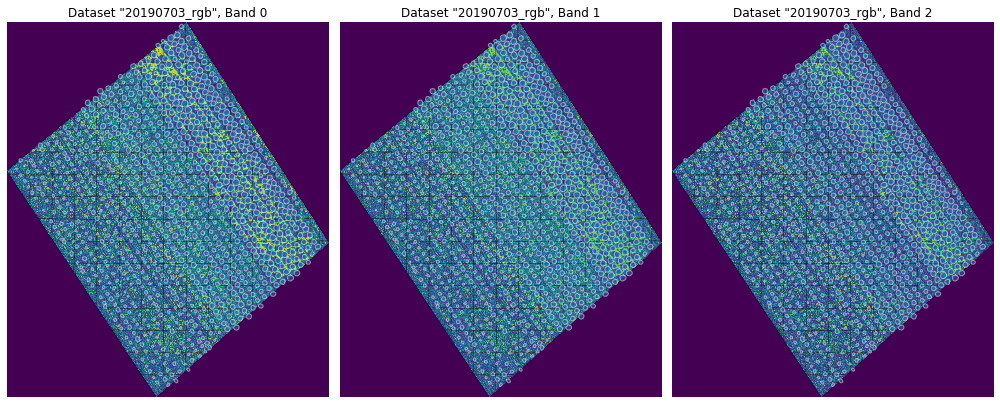

In [8]:
d_0719_rgb.visualize(with_grid=True, with_mask=True)

### NIR

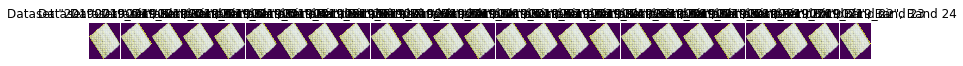

In [14]:
d_0719_nir.visualize(with_grid=True, with_mask=True)

### VIS

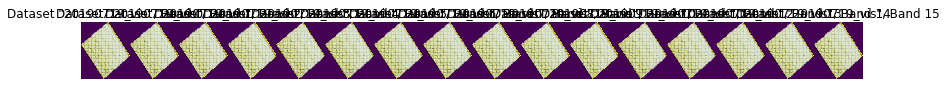

In [15]:
d_0719_vis.visualize(with_grid=True, with_mask=True)

# Analyze Bands

## Create Dataset
Cut out all Plants by the corresponding mask and species and save the median band values per species and image to a dataframe

In [221]:
from skimage.morphology import disk
from skimage.morphology import erosion

spec_1 = []
spec_5 = []

grid_id_values = list(set(di.df.grid_id.tolist()))
date_values = list(set(di.df.date.tolist()))

for i, s in enumerate(grid_id_values):
    if i % 50 == 0 and i != 0:
        print("Processed {} of {} images...".format(i, len(grid_id_values)))
    img = []
    for band in date_values[::-1]:
        try:
            img_tmp, msk = di.get_pair(s, band)
            msk = erosion(msk, disk(20))
            for c in range(img_tmp.shape[-1]):
                img.append(img_tmp[:, :, c])
        except:
            print("exeption occured")
    img = np.stack(img, axis=-1)
    tmp_1 = []
    tmp_5 = []
    for band in range(img.shape[-1]):
        arr = np.multiply(img[:, :, band], msk==1)
        arr[arr == 0] = np.nan
        tmp_1.append(np.nanmedian(arr))
        arr = np.multiply(img[:, :, band], msk==2)
        arr[arr == 0] = np.nan
        tmp_5.append(np.nanmedian(arr))
    spec_1.append(tmp_1)
    spec_5.append(tmp_5)

Processed 50 of 153 images...
Processed 100 of 153 images...
Processed 150 of 153 images...


### Create Dataframe

In [222]:
df = pd.DataFrame(data=np.concatenate((np.array(spec_1), np.array(spec_5))),
                 columns=["rgb" + str(band) for band in range(1, 4)] +
                 ["nir" + str(band) for band in range(1, 26)] + 
                 ["vis" + str(band) for band in range(1, 17)])

### Add Species Column

In [223]:
df['species'] = ['plant 1001' for _ in range(len(np.array(spec_1)))] + ['plant 1005' for _ in range(len(np.array(spec_5)))]

### Remove 'Nan' Columns

In [224]:
df = df.dropna()

### Equalize length of both dataframes

In [225]:
min_length = min(len(df[df['species'] == 'plant 1001']), len(df[df['species'] == 'plant 1005']))

df = pd.concat([df[df['species'] == 'plant 1001'].sample(min_length), 
              df[df['species'] == 'plant 1005'].sample(min_length)])
df.sample(3)

rgb1      rgb2      rgb3      nir1      nir2      nir3      nir4  \
23   0.439020  0.483222  0.349969  0.498907  0.508234  0.451165  0.391063   
271  0.267577  0.319089  0.229399  0.524482  0.526294  0.469899  0.406952   
170  0.362416  0.401601  0.280329  0.513906  0.515543  0.456094  0.394328   

         nir5      nir6      nir7  ...      vis8      vis9     vis10  \
23   0.384778  0.735892  0.761058  ...  0.403367  0.452068  0.384526   
271  0.398626  0.740316  0.754726  ...  0.215940  0.251888  0.215759   
170  0.389770  0.732138  0.752057  ...  0.311765  0.354930  0.302373   

        vis11     vis12     vis13     vis14     vis15     vis16     species  
23   0.490015  0.485558  0.312599  0.348657  0.260328  0.241908  plant 1001  
271  0.270184  0.264559  0.174117  0.194404  0.149156  0.138065  plant 1005  
170  0.383319  0.383357  0.243804  0.270854  0.204230  0.190411  plant 1005  

[3 rows x 45 columns]

## Plot Correlation Matrix of all Features 
Analyze the measured Values for each set of Bands with a correlation matrix. 

Text(0.5, 0.98, 'Correlations of different Bands')

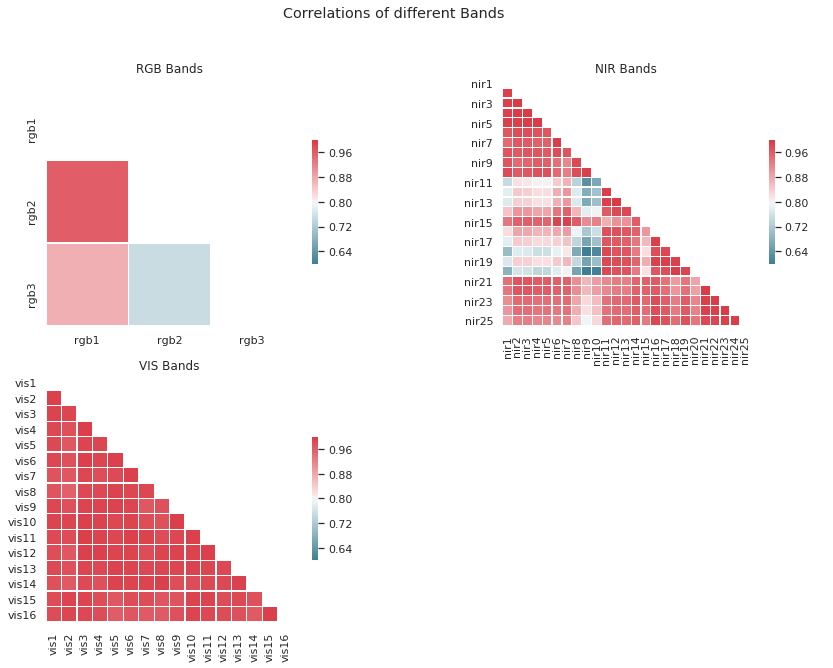

In [26]:
sns.set(style="white")
# Compute the correlation matrix
corr_rgb = df[["rgb" + str(i) for i in range(1, 4)]].corr()
corr_nir = df[["nir" + str(i) for i in range(1, 26)]].corr()
corr_vis = df[["vis" + str(i) for i in range(1, 17)]].corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(2, 2,figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Generate a mask for the upper triangle
mask_rgb = np.zeros_like(corr_rgb, dtype=np.bool)
mask_rgb[np.triu_indices_from(mask_rgb)] = True
mask_nir = np.zeros_like(corr_nir, dtype=np.bool)
mask_nir[np.triu_indices_from(mask_nir)] = True
mask_vis = np.zeros_like(corr_vis, dtype=np.bool)
mask_vis[np.triu_indices_from(mask_vis)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_rgb, cmap=cmap, mask=mask_rgb, ax=ax[0, 0],
            square=True, linewidths=.2, cbar_kws={"shrink": .5}, vmin=0.6, vmax=1.0)
sns.heatmap(corr_nir, cmap=cmap, mask=mask_nir, ax=ax[0, 1],
            square=True, linewidths=.2, cbar_kws={"shrink": .5}, vmin=0.6, vmax=1.0)
sns.heatmap(corr_vis, cmap=cmap, mask=mask_vis, ax=ax[1, 0],
            square=True, linewidths=.2, cbar_kws={"shrink": .5}, vmin=0.6, vmax=1.0)

ax[0, 0].set_title("RGB Bands")
ax[0, 1].set_title("NIR Bands")
ax[1, 0].set_title("VIS Bands")
ax[1, 1].axis('off')

fig.suptitle("Correlations of different Bands")

When we look at the three plots we can notice the following:
- **RGB**: We see that especially RGB2 and RGB3 are diverging from each other whereas RGB1 is more collinear to the other 2
- **NIR**: A majority of the bands seem to correlate strongly. Whereby between a part of the bands 1 - 20 deviations occur.
- **VIS**: Here, all bands seem to have strong correlations to each other

According to (https://www.sciencedirect.com/topics/earth-and-planetary-sciences/multispectral-image), multispectral image bands are often highly correlated, i.e. they are visually and numerically similar. The correlation between spectral bands arises from a combination of the following factors:
- Material spectral correlation
- Topography
- Sensor band overlap

This mostly matches with the made analyis made by now.

## Feature Importance
To get more insight on which bands contribute the most independently of each other, one can train supervised classifier as mentioned in https://github.com/WillKoehrsen/feature-selector

This method works by finding feature importances using a gradient boosting machine implemented in the LightGBM library.

To reduce variance in the calculated feature importances, the model is trained a default 10 times. The model is also by default trained with early stopping using a validation set (15% of the training data) to identify the optimal number of estimators to train. 

In [227]:
from utils.feature_selector import FeatureSelector

In [230]:
fs = FeatureSelector(data = df.drop(columns = ['species']), labels = df['species'])

fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	valid_0's auc: 0.717639	valid_0's binary_logloss: 0.617277
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.674964	valid_0's binary_logloss: 0.66041
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.797297	valid_0's binary_logloss: 0.661398
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.745377	valid_0's binary_logloss: 0.619484
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's auc: 0.711593	valid_0's binary_logloss: 0.655222
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.757112	valid_0's binary_logloss: 0.679921
T

We can now plot the features by their importance to the classification result:

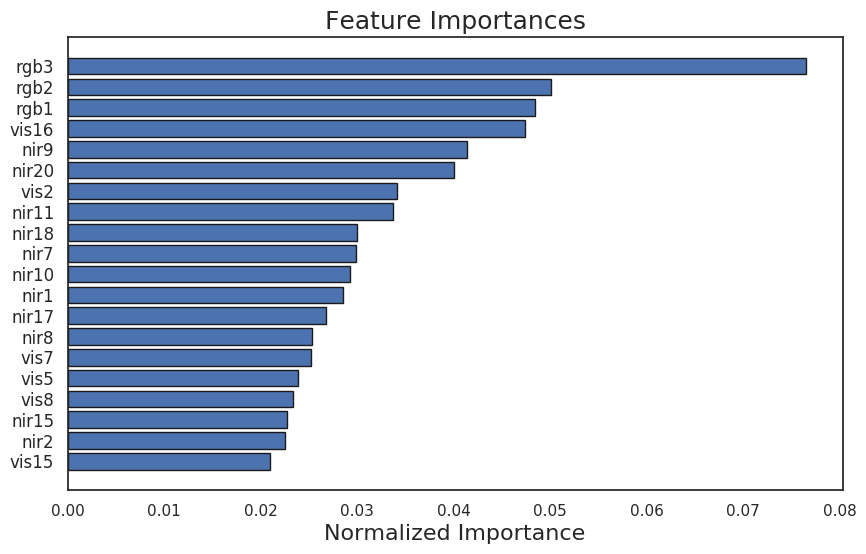

In [31]:
fs.plot_feature_importances(threshold = 0.8, plot_n = 20)

What can be noticed is that the RGB contribute the most to the classification result. This is probably due to the fact that the RGB bands contain a wide range of spectra.

## Pairplot the 5 most important bands

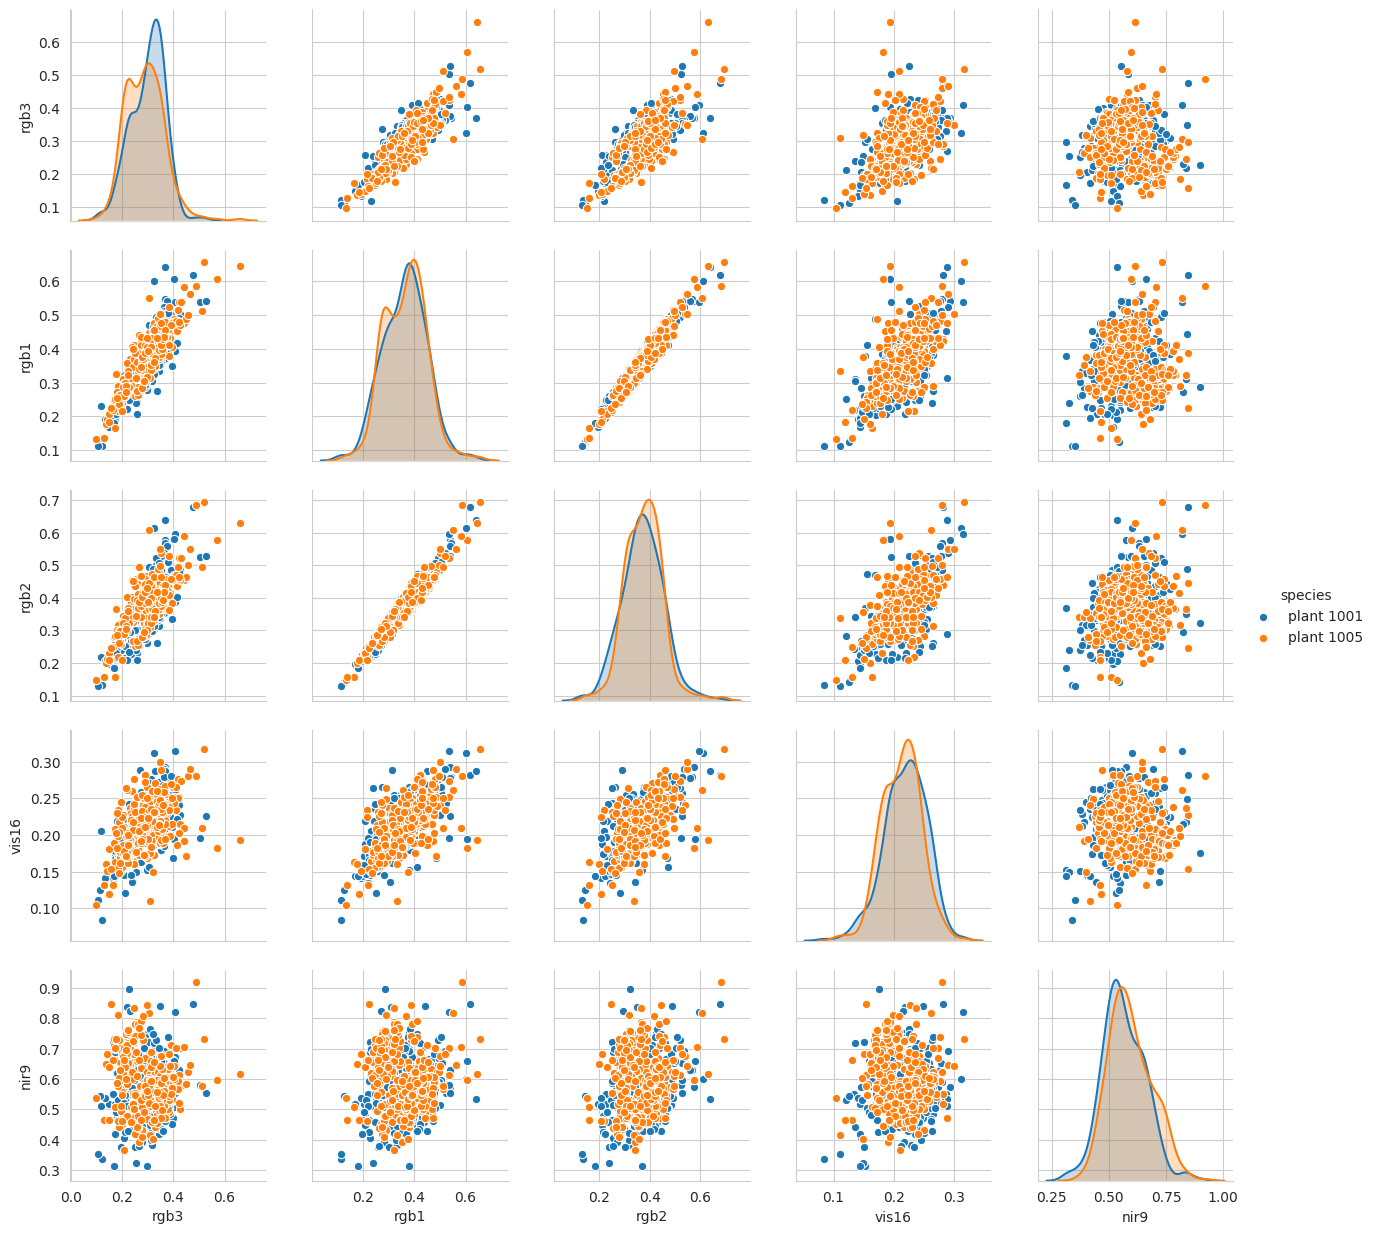

In [58]:
_ = sns.pairplot(df[fs.feature_importances.head(5).feature.tolist() + ['species']], hue='species')

## Pairplot the 5 most unimportant bands

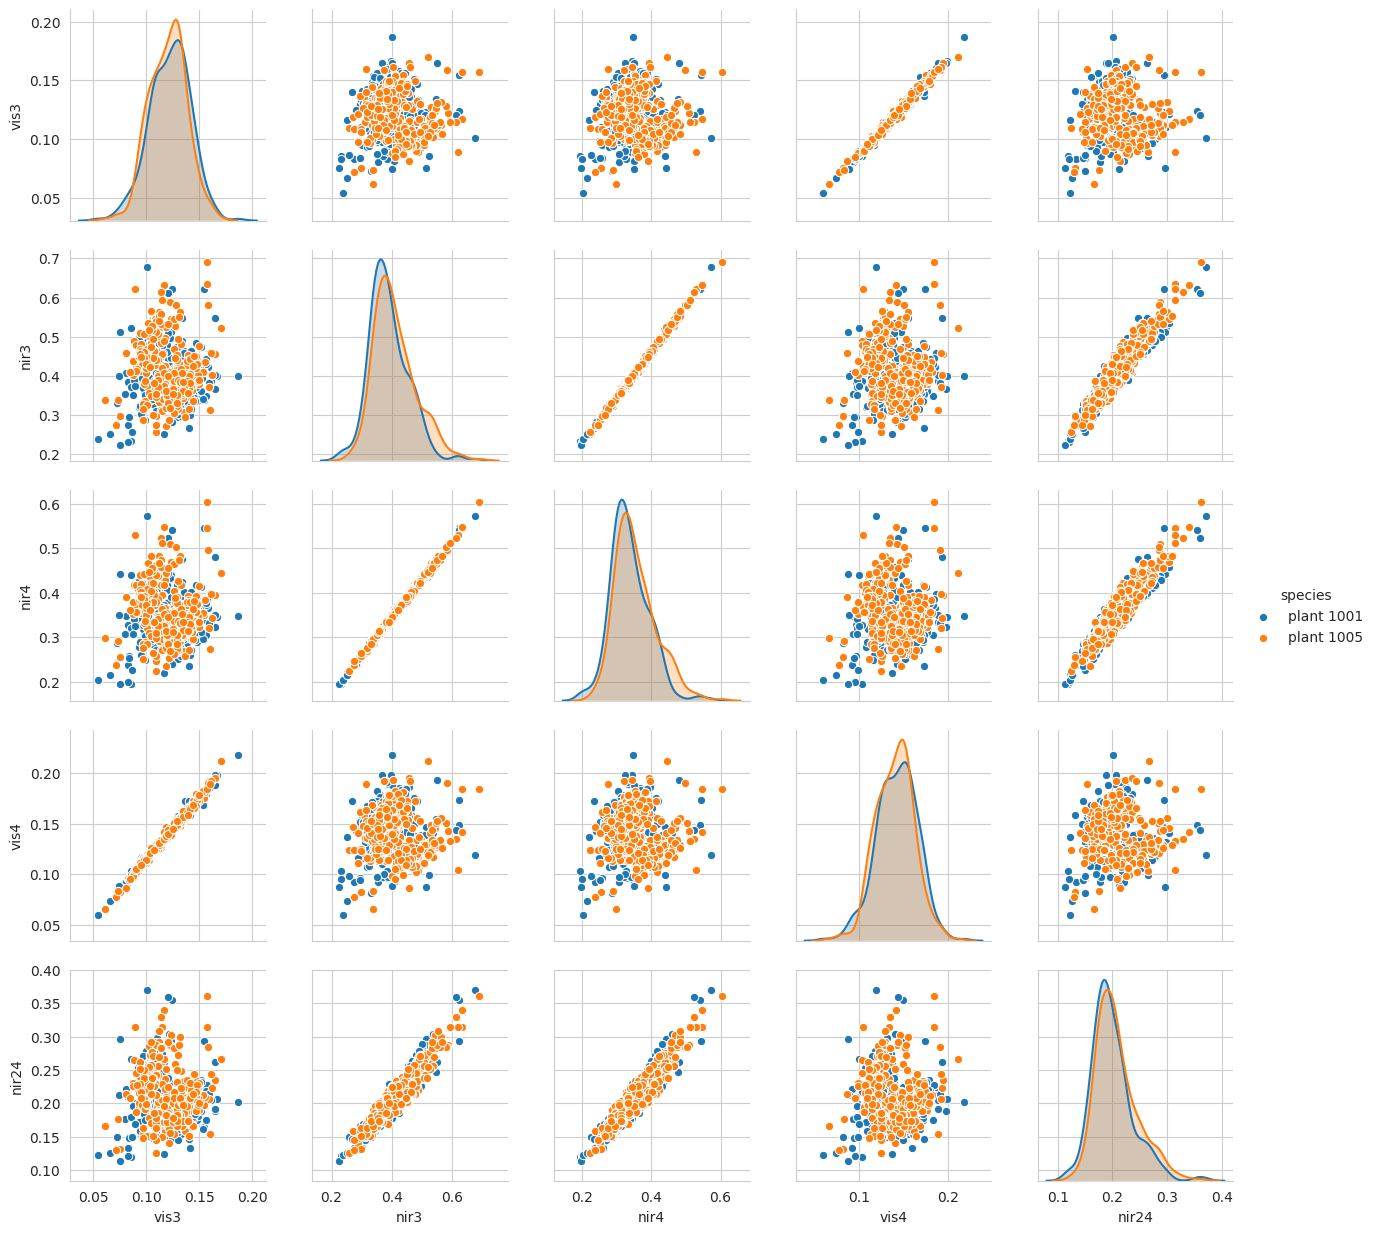

In [59]:
_ = sns.pairplot(df[fs.feature_importances.tail(5).feature.tolist() + ['species']], hue='species')

## Principal Component Analysis
Until now we have looked at every original spectral band.

Also according to (https://www.sciencedirect.com/topics/earth-and-planetary-sciences/multispectral-image) this is inefficient because of the redundancy we have seen in Chapter 2.2. 

What can be done about this is a Principal Component Analysis (PCA) which transforms the datapoints into a new featurespace with the aim of maximizing variance. The transformation is therefore applied in such a way that linearly correlated variables get transformed into uncorrelated variables. This condenses information from a high dimensional feature space into a lower dimensional feature space. 

Get a sample image from the current dataset:

(5247, 4052, 25)


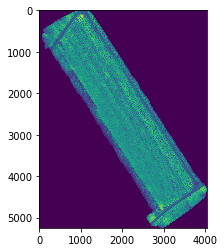

In [45]:
with rio.open(d_0822_nir.path) as src:
    arr = src.read()
    transform = src.transform
    arr = np.clip(arr, a_min=0.0, a_max=None)
    arr = np.moveaxis(arr, 0, 2)
    plt.imshow(arr[:, :, 0])
    print(arr.shape)

Convert the 2D band image into a 1d featurevector and remove the RGB bands:

In [46]:
#img = arr[1000:2500, 1000:2500, :]
img = arr
n_bands = img.shape[-1]

matrix = np.zeros((img[:, :, 0].size, n_bands))

for i in range(n_bands):
    img_flatten = img[:, :, i].flatten()
    matrix[:, i] = img_flatten
matrix.transpose().shape

(25, 21260844)

Calculate the Covariance and the corresponding eigenvalues and vectors:

In [47]:
cov = np.cov(matrix.transpose())
eig_val, eig_vec = np.linalg.eig(cov)
print("Eigenvalues: \n {}".format(eig_val))

Eigenvalues: 
 [4.89385829e+04 3.84659318e+02 5.31244313e+01 2.18441231e+01
 8.91344482e+00 5.69823453e+00 3.12310090e+00 2.20207230e+00
 1.34009201e+00 1.06751461e+00 9.21263891e-01 6.49927186e-01
 5.28273814e-01 4.70688766e-01 4.39058111e-01 3.94594795e-01
 1.67074481e-01 1.95897344e-01 2.01992986e-01 3.42252072e-01
 2.37432335e-01 2.51202374e-01 3.12783909e-01 2.74972916e-01
 2.88151548e-01]


Sorting eigenvalues and vectors

In [48]:
order = eig_val.argsort()[::-1]
eig_val = eig_val[order]
eig_vec = eig_vec[:,order]

Keeping only the 10 most "important" Components and projecting data on eigenvector directions which gives us the Principal Components

In [49]:
#n_bands = 10

#matrix = matrix[:, :n_bands]
#eig_vec = eig_vec[:n_bands, :n_bands]
#eig_val = eig_val[:n_bands]

pc = np.matmul(matrix, eig_vec)   #cross product
pc.shape

(21260844, 25)

### Pairplot of the original data and transformed Pricipal Components

In [ ]:
ax1 = sns.pairplot(pd.DataFrame(matrix,
                columns = ['Band ' + str(i) for i in range(1, n_bands+1)]),
                diag_kind='kde', plot_kws={"s": 3})

ax1.fig.suptitle("Pair plot of Band images")

ax2 = sns.pairplot(pd.DataFrame(pc,
                columns = ['PC ' + str(i) for i in range(1, n_bands+1)]),
                diag_kind='kde', plot_kws={"s": 3})

ax2.fig.suptitle("Pair plot of Principle Components")

### Information per Component

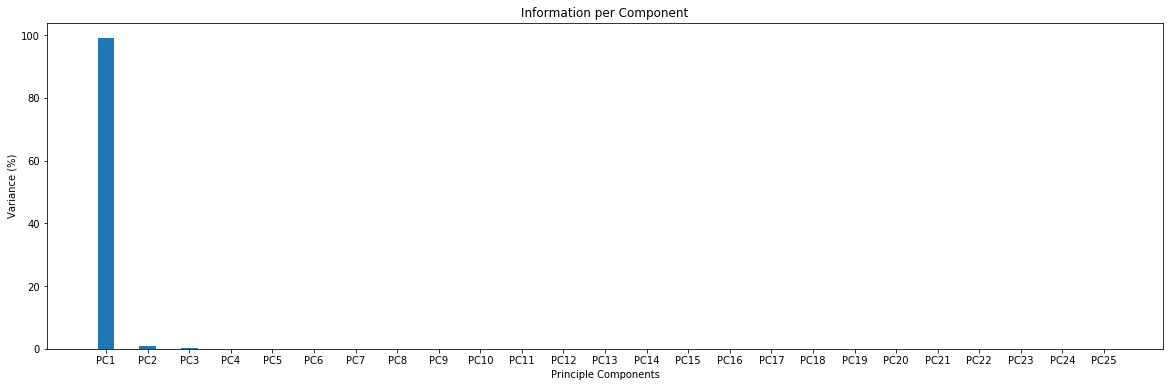

In [50]:
plt.figure(figsize=(20,6))
plt.bar(list(range(1, n_bands+1)), 
        eig_val/sum(eig_val)*100,
        align='center',width=0.4, 
        tick_label = ['PC' + str(i) for i in range(1, n_bands+1)])
plt.ylabel('Variance (%)')
plt.xlabel('Principle Components')
plt.title('Information per Component');

In [51]:
pc.shape

(21260844, 25)

## Reshaping 1-D arrays to 2-D arrays

In [52]:
import cv2
img_shape = img.shape

pc_2d = np.zeros((img_shape[0], img_shape[1], n_bands))
for i in range(n_bands):
    pc_2d[:, :, i] = pc[:, i].reshape(-1, img_shape[1])
    
for i in range(n_bands):
    pc_2d[:,:,i] = cv2.normalize(pc_2d[:,:,i], np.zeros(img_shape),0.0,1.0 ,cv2.NORM_MINMAX)
    pc_2d[:,:,i] = np.clip(pc_2d[:,:,i], 0.0, 1.0)

## Display Principle Components

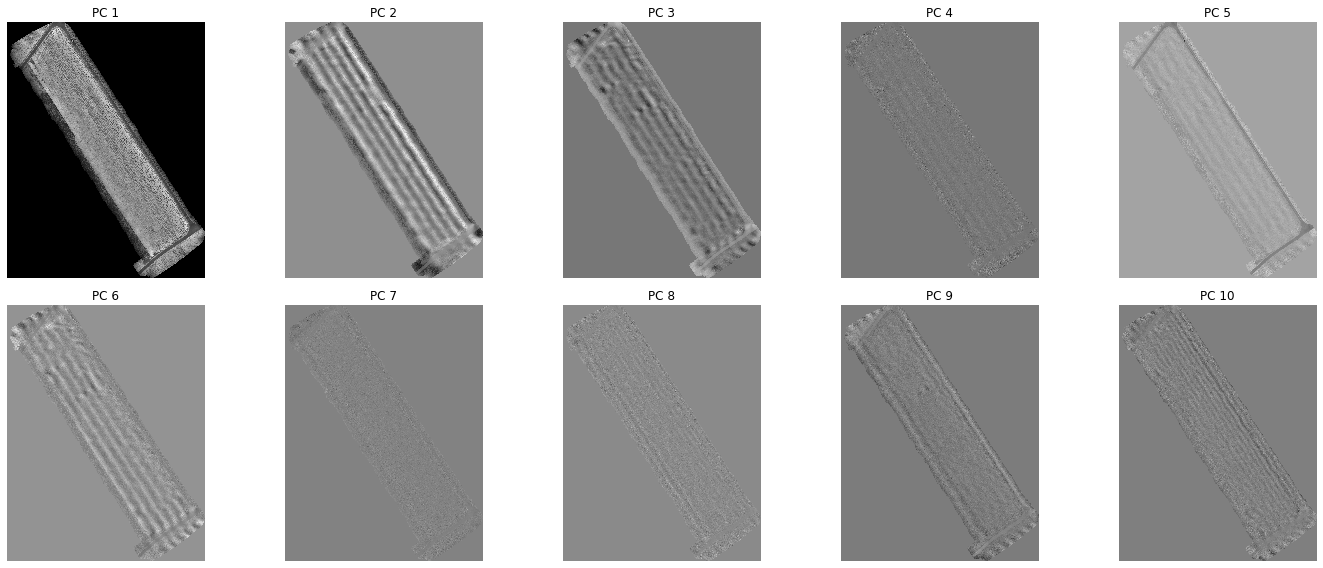

In [53]:
fig,axes = plt.subplots(2,5,figsize=(20,8))

axes = axes.ravel()

for i in range(10):
    axes[i].imshow(pc_2d[:,:,i],cmap='gray', vmin=0.0, vmax=1.0)
    axes[i].set_title('PC {}'.format(i+1))
    axes[i].axis('off')

plt.tight_layout()

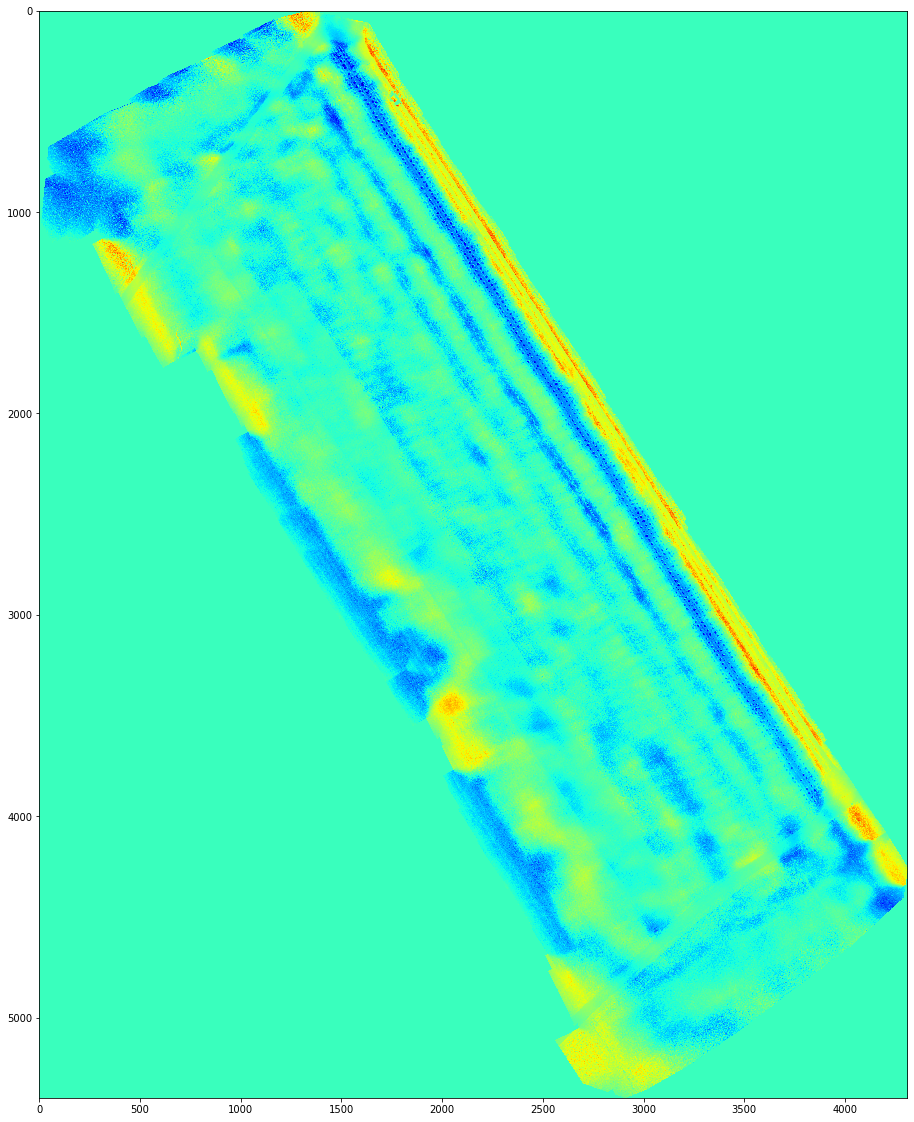

In [19]:
#0703
plt.figure(figsize=(20, 20))
plt.imshow(pc_2d[:, :, 1], cmap='jet')

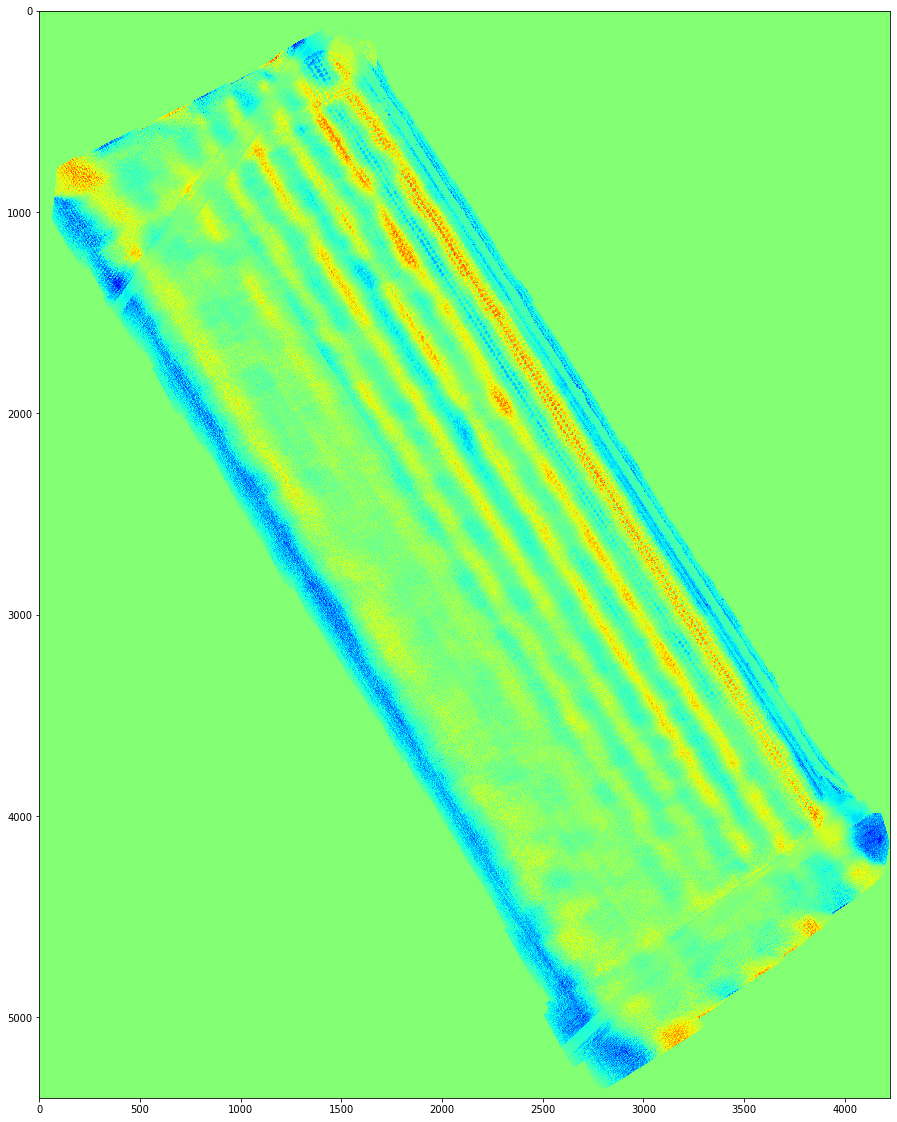

In [42]:
#0719
plt.figure(figsize=(20, 20))
plt.imshow(pc_2d[:, :, 1], cmap='jet')

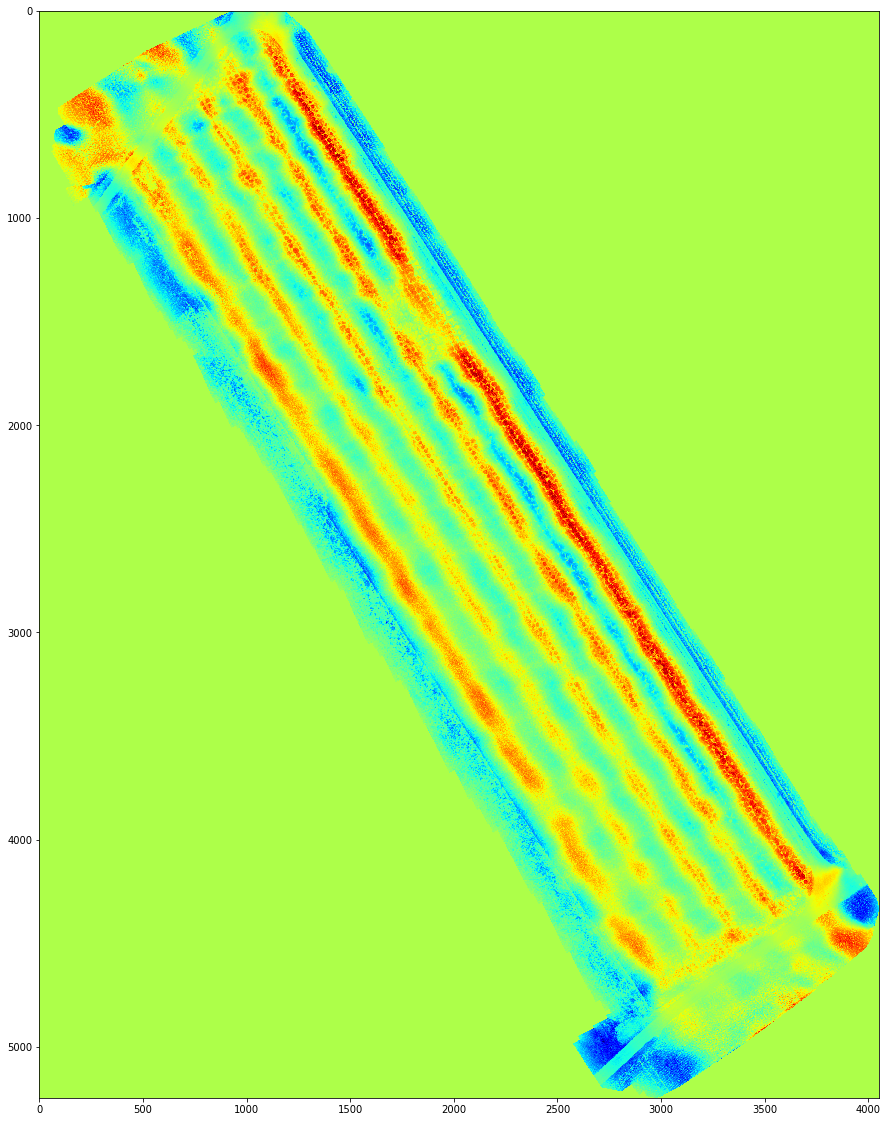

In [54]:
#0822
plt.figure(figsize=(20, 20))
plt.imshow(pc_2d[:, :, 1], cmap='jet')

In [55]:
pc_2d[:, :, 0:2].shape
tmp = np.moveaxis(pc_2d[:, :, 0:2], 2, 0)
tmp.shape

(2, 5247, 4052)

In [56]:
from rasterio.transform import from_origin
from rasterio.crs import CRS

dataset = rio.open('0822_pc12', 'w', driver='GTiff',
                    height = tmp.shape[1], width = tmp.shape[2],
                    count=2, dtype=str(pc_2d[:, :, 1].dtype),
                    crs=CRS.from_epsg(32632),
                    transform=transform)

dataset.write(tmp)
dataset.close()

## Overlap of the thirst 3 Components

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1499.5, 1499.5, -0.5)

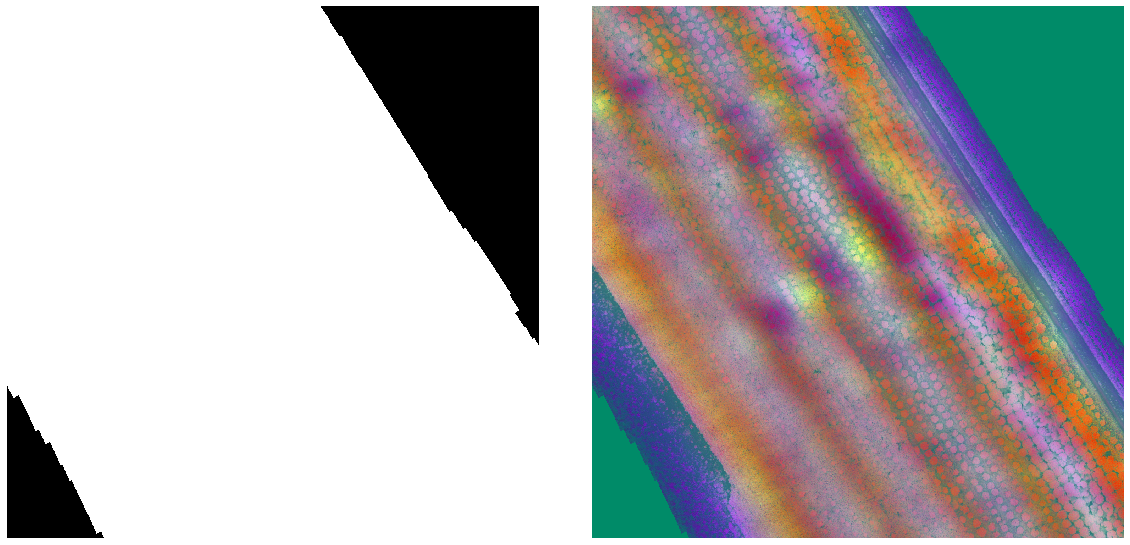

In [47]:
fig,axes = plt.subplots(1,2,figsize=(20,20),
                        sharex='all', sharey='all')   
fig.subplots_adjust(wspace=0.1, hspace=0.15)
axes[0].imshow(img[:,:,0:3])
axes[0].axis('off')
axes[1].imshow(pc_2d[:,:,:3][:,:,[0,2,1]])
axes[1].axis('off')